# MIE524 - Lab 2 - Machine Learning


### Setup
Let's setup Spark on the Colab environment.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=0db6d512372843a8bbbac1f0ff493376bf369f741c5a65abfb0be0ebde711413
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 18 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected packag

Authenticate a Google Drive client to download the files needed in the Spark job.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Load packages.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize Spark context.

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

### Data
![MNIST](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png)

We will be using the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset throughout this lab. a large collection of handwritten digits that is widely used for training and testing in the field of machine learning.

This loads the MNIST dataset in the LibSVM format, where each digit is represented as a sparse vector of grayscale pixel values.

In [ ]:
id='1aJrdYMVmmnUKYhLTlXtyB0FQ9gYJqCrs'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mnist-digits-train.txt')

id='1yLwxRaJIyrC03yxqbTKpedMmHEF86AAq'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mnist-digits-test.txt')

In [ ]:
training = spark.read.format("libsvm").option("numFeatures","784").load("mnist-digits-train.txt")
test = spark.read.format("libsvm").option("numFeatures","784").load("mnist-digits-test.txt")

# Cache data for multiple uses
training.cache()
test.cache()

DataFrame[label: double, features: vector]

In [ ]:
training.show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
training.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
test.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)




## PART 1 - Random Forrest
We will build a random forrest model from scratch.

In [ ]:
import numpy as np
import math
import random

from tqdm import tqdm

from sklearn import tree
from sklearn.utils import resample

from pyspark.ml.feature import StringIndexer, VectorIndexer


Define parameters

**n_estimators**: int - The number of classification trees that are used.

**max_features**: int - The maximum number of features that the classification trees are allowed to use.

**min_samples_split**: int - The minimum number of samples needed to make a split when building a tree.

**min_gain**: float - The minimum impurity required to split the tree further.

**max_depth**: int - The maximum depth of a tree.

**n_samples**: int - The number of samples in each tree is max_samples * X.shape[0].

In [ ]:
n_estimators = 20
max_features = 20
min_samples_split = 2
min_impurity_decrease = 0
max_depth = None
n_samples = 0.05

n_features = len(training.select('features').first()[0])
# If max_features have not been defined => select it as
# sqrt(n_features)
if not max_features:
    max_features = int(math.sqrt(n_features))

Initialize the set of decision trees, we will use scikit's decision tree implementation

In [ ]:
trees = []
for _ in range(n_estimators):
    trees.append(
        tree.DecisionTreeClassifier(
            min_samples_split=min_samples_split,
            min_impurity_decrease=min_impurity_decrease,
            max_depth=max_depth))

Let's create sample subsets for training for each tree.

In [ ]:
# Create sample subsets for each decision tree
subsets = []
for i in tqdm(range(n_estimators)):
    subsets.append(training.sample(True, n_samples, 524))

100%|██████████| 20/20 [00:00<00:00, 221.08it/s]


In [ ]:
# Convert data to pandas dataframe to use with scikit
subsets_pd = []
for i in tqdm(range(n_estimators)):
    X_subset = pd.DataFrame(subsets[i].toPandas().apply(lambda row: row['features'].toArray(), axis=1).tolist())
    y_subset = subsets[i].toPandas()[['label']]
    subsets_pd.append([X_subset, y_subset])

100%|██████████| 20/20 [01:04<00:00,  3.25s/it]


Create the training loop (*fit* function).

In [ ]:
# training loop
for i in range(n_estimators):
    X_subset = subsets_pd[i][0]
    y_subset = subsets_pd[i][1]

    # Feature bagging (select random subsets of the features)
    idx = np.random.choice(range(n_features), size=max_features, replace=True)
    # Save the indices of the features for prediction
    trees[i].feature_indices = idx
    # Choose the features corresponding to the indices
    X_subset = X_subset.iloc[:, idx]
    # Fit the tree to the data
    trees[i].fit(X_subset, y_subset)

Now we are ready to make some predictions.

In [ ]:
X_test = pd.DataFrame(test.toPandas().apply(lambda row: row['features'].toArray(), axis=1).tolist())
y_test = test.toPandas()[['label']]

y_preds = np.empty((X_test.shape[0], len(trees)))
# Let each tree make a prediction on the data
for i, t in enumerate(trees):
    # Indices of the features that the tree has trained on
    idx = t.feature_indices
    # Make a prediction based on those features
    prediction = t.predict(X_test.iloc[:, idx])
    y_preds[:, i] = prediction

y_pred = []
# For each sample
for sample_predictions in y_preds:
    # Select the most common class prediction
    y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())

Putting everything together...

In [ ]:
class RandomForest():
    """Random Forest classifier. Uses a collection of classification trees that
    trains on random subsets of the data using a random subsets of the features.

    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    max_features: int
        The maximum number of features that the classification trees are allowed to
        use.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity_decrease: float
        A node will be split if this split induces a decrease of the impurity
        greater than or equal to this value.
    max_depth: int
        The maximum depth of a tree.
    n_samples: int
        The number of samples in each tree is max_samples * X.shape[0].
    """
    def __init__(self, n_estimators=100, max_features=None, min_samples_split=2,
                 min_impurity_decrease=0, max_depth=float("inf"), n_samples = 1):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.min_impurity_decrease = min_impurity_decrease
        self.max_depth = max_depth
        self.n_samples = n_samples

        # Initialize decision trees
        self.trees = []
        for _ in range(n_estimators):
            self.trees.append(
                tree.DecisionTreeClassifier(
                    min_samples_split=self.min_samples_split,
                    min_impurity_decrease=min_impurity_decrease,
                    max_depth=self.max_depth))

    def fit(self, X, y):
        n_features = np.shape(X)[1]
        # If max_features have not been defined => select it as
        # sqrt(n_features)
        if not self.max_features:
            self.max_features = int(math.sqrt(n_features))

        # Create sample subsets
        subsets = []
        for i in tqdm(range(self.n_estimators)):
            sample = pd.concat([X,y], axis = 1).sample(frac=self.n_samples, replace=True, random_state=524)
            subsets.append([sample.drop('label', axis=1), sample[['label']]])


        for i in range(self.n_estimators):
            X_subset = subsets[i][0]
            y_subset = subsets[i][1]

            # Feature bagging (select random subsets of the features)
            idx = np.random.choice(range(n_features), size=max_features, replace=True)
            # Save the indices of the features for prediction
            self.trees[i].feature_indices = idx
            # Choose the features corresponding to the indices
            X_subset = X_subset.iloc[:, idx]
            # Fit the tree to the data
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, X):
        y_preds = np.empty((X.shape[0], len(self.trees)))
        # Let each tree make a prediction on the data
        for i, tree in enumerate(self.trees):
            # Indices of the features that the tree has trained on
            idx = tree.feature_indices
            # Make a prediction based on those features
            prediction = tree.predict(X.iloc[:, idx])
            y_preds[:, i] = prediction

        y_pred = []
        # For each sample
        for sample_predictions in y_preds:
            # Select the most common class prediction
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
        return y_pred

Let's train and predict using the RandomForest class.

In [ ]:
# Initialize classifier
clf = RandomForest(n_estimators = 20, max_features = 20,
                   min_samples_split = 2, min_impurity_decrease = 0,
                   max_depth = None, n_samples = 0.05)

In [ ]:
# Prepare data
X_training = pd.DataFrame(training.toPandas().apply(lambda row: row['features'].toArray(), axis=1).tolist())
y_training = training.toPandas()[['label']].astype(int)

X_test = pd.DataFrame(test.toPandas().apply(lambda row: row['features'].toArray(), axis=1).tolist())
y_test = test.toPandas()[['label']].astype(int)

In [ ]:
# Fit model to data
clf.fit(X_training, y_training)

100%|██████████| 20/20 [00:03<00:00,  5.41it/s]


In [ ]:
y_pred = clf.predict(X_test)

### Evaluate model performance

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.97      0.89       980
           1       0.87      0.98      0.92      1135
           2       0.83      0.83      0.83      1032
           3       0.78      0.80      0.79      1010
           4       0.78      0.86      0.82       982
           5       0.83      0.64      0.72       892
           6       0.90      0.91      0.90       958
           7       0.85      0.80      0.82      1028
           8       0.79      0.66      0.72       974
           9       0.75      0.74      0.74      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



Confusion matrix:
[[ 948    1    5    4    0    3   11    2    5    1]
 [   0 1117    1    5    2    0    4    2    3    1]
 [  37   23  855   29   20    4    9   12   29   14]
 [  31   25   47  809    3   30    7   14   34   10]
 [   3   16    7    2  840    3   19    8    5   79]
 [  49   22   15   71   23  570   32   14   72   24]
 [  21   15    6    5   21   13  870    1    5    1]
 [   1   24   34   16   27    8    2  822    5   89]
 [  38   27   44   87   24   50   12   13  644   35]
 [  11   11   10   15  112    9    3   81    9  748]]


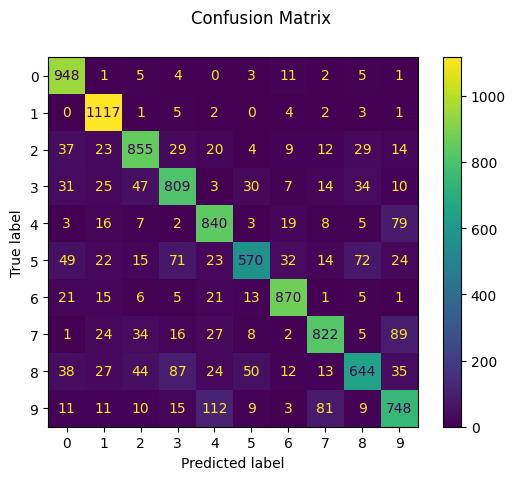

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

Let's compare with scikit's implementation of random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

sk_clf = RandomForestClassifier(n_estimators = 20, max_features = 20,
                   min_samples_split = 2, min_impurity_decrease = 0,
                   max_depth = None, max_samples = 0.05)

sk_clf.fit(X_training, y_training)

y_pred_sk = sk_clf.predict(X_test)

<ipython-input-24-f0b75162a5f5>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  sk_clf.fit(X_training, y_training)


In [ ]:
print(classification_report(y_test, y_pred_sk))


              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.97      0.99      0.98      1135
           2       0.91      0.92      0.91      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.90      0.87      0.89       892
           6       0.94      0.95      0.94       958
           7       0.94      0.90      0.92      1028
           8       0.93      0.87      0.90       974
           9       0.89      0.90      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Let's see MLlib's performance, which can fully leverage the datatype of libsvm.

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(training.union(test))

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(training.union(test))


# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=20)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(training)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.show(5)


+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------+
|label|            features|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+--------------+
|  7.0|(784,[202,203,204...|         1.0|(784,[202,203,204...|[0.43416509836346...|[0.02170825491817...|       1.0|           7.0|
|  2.0|(784,[94,95,96,97...|         3.0|(784,[94,95,96,97...|[1.47213964597123...|[0.07360698229856...|       3.0|           2.0|
|  1.0|(784,[128,129,130...|         0.0|(784,[128,129,130...|[15.2800174556904...|[0.76400087278452...|       0.0|           1.0|
|  0.0|(784,[124,125,126...|         5.0|(784,[124,125,126...|[0.00483597991176...|[2.41798995588244...|       5.0|           0.0|
|  4.0|(784,[150,151,159...|         8.0|(784,[150,151,159...|[0.18773018229796...|

In [ ]:
# predictions.rdd.map(lambda x: x.prediction).collect()

y_pred_spark = predictions.rdd.map(lambda x: x.prediction).collect()
y_test_spark = predictions.rdd.map(lambda x: x.indexedLabel).collect()

In [ ]:
print(classification_report(y_test_spark, y_pred_spark))


              precision    recall  f1-score   support

         0.0       0.88      0.98      0.92      1135
         1.0       0.85      0.87      0.86      1028
         2.0       0.82      0.83      0.83      1010
         3.0       0.87      0.84      0.85      1032
         4.0       0.78      0.83      0.80      1009
         5.0       0.87      0.97      0.92       980
         6.0       0.85      0.87      0.86       958
         7.0       0.82      0.81      0.81       974
         8.0       0.83      0.80      0.82       982
         9.0       0.91      0.64      0.75       892

    accuracy                           0.85     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.85      0.84     10000



## PART 2 - Deep Learning
We will build a simple feed forwarnd neural network in this part.

![FFW](https://images.deepai.org/django-summernote/2019-06-06/5c17d9c2-0ad4-474c-be8d-d6ae9b094e74.png)

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

### Torch Introduction

Initializing a tensor

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

print(x_data)

tensor([[1, 2],
        [3, 4]])


Initialize a tensor with random values

In [ ]:
x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(x_rand)

tensor([[0.2682, 0.9056],
        [0.3253, 0.9450]])


Attributes of a tensor

In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")
print(tensor)

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu
tensor([[0.9760, 0.6392, 0.4033, 0.8794],
        [0.0653, 0.8668, 0.0653, 0.0250],
        [0.1764, 0.7576, 0.2515, 0.4449]])


Standard operations on tensors

In [ ]:
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")

First row: tensor([0.9760, 0.6392, 0.4033, 0.8794])
First column: tensor([0.9760, 0.0653, 0.1764])
Last column: tensor([0.8794, 0.0250, 0.4449])


In [ ]:
tensor[:,1] = 0
print(tensor)

tensor([[0.9760, 0.0000, 0.4033, 0.8794],
        [0.0653, 0.0000, 0.0653, 0.0250],
        [0.1764, 0.0000, 0.2515, 0.4449]])


Arithmetic operations on tensors

In [ ]:
# matrix multiplication of two tensors, y1 and y2 are equivalent

y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)


In [ ]:
# element-wise product of the elemnts of the two tensors

z1 = tensor * tensor
z2 = tensor.mul(tensor)

### Prepare data

In [ ]:
#dataset
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 80915721.11it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34739229.66it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21913887.45it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5877978.64it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# dataloader - used to perform mini batch or stochastic gradient descent by acting as an iterable.
batch_size = 100

train_loader = DataLoader(dataset=training_data,shuffle=True,batch_size=batch_size)
test_loader = DataLoader(dataset=test_data,shuffle=True,batch_size=batch_size)

In [ ]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([100, 1, 28, 28])
Shape of y: torch.Size([100]) torch.int64


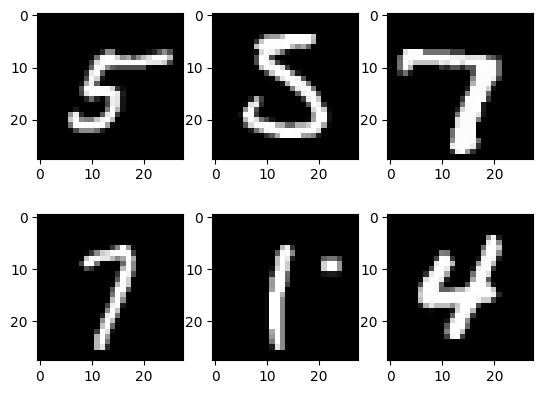

In [ ]:
examples = iter(test_loader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

### Create the neural network

`super()` returns a temporary object of the superclass that then allows you to call that superclass’s methods.

In [ ]:
# Create a neural network with 2 linear hidden layers with a Relu activation function
from torch import nn
class net(nn.Module):
    def __init__(self,input_size,output_size, hidden_size):
        super(net,self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,output_size)
    def forward(self,x):
        output = self.l1(x)
        output = self.relu(output)
        output = self.l2(output)
        return output

input_size = 28 * 28
output_size = 10
hidden_size = 500

model = net(input_size, output_size, hidden_size)
print(model)

net(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)


Define loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

Define the optimizer (specify optimization method, learning rate, etc.)

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training loop

In [ ]:
num_epochs = 2
n_total_steps = len(train_loader)

lossval = []
for j in range(num_epochs):
    for i, (x_train, y_train) in enumerate(train_loader):
        #prediction
        y_pred = model(x_train.reshape(-1, 28*28))

        #calculating loss
        loss = criterion(y_pred,y_train.reshape(-1))

        #calculating accuracy
        correct = (y_pred.argmax(1) == y_train).type(torch.float).sum().item()
        accuracy_batch = correct/batch_size

        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print batch information
        if (i+1) % 100 == 0:
            print (f'Epoch [{j+1}/{num_epochs}], Step[{i+1}/{n_total_steps}], Train Accuracy: {accuracy_batch:.2f}%, Loss: {loss.item():.4f}')
            lossval.append(loss.item())


Epoch [1/2], Step[100/600], Train Accuracy: 0.87%, Loss: 0.5208
Epoch [1/2], Step[200/600], Train Accuracy: 0.92%, Loss: 0.2243
Epoch [1/2], Step[300/600], Train Accuracy: 0.95%, Loss: 0.1516
Epoch [1/2], Step[400/600], Train Accuracy: 0.90%, Loss: 0.3066
Epoch [1/2], Step[500/600], Train Accuracy: 0.99%, Loss: 0.0862
Epoch [1/2], Step[600/600], Train Accuracy: 0.96%, Loss: 0.1945
Epoch [2/2], Step[100/600], Train Accuracy: 0.98%, Loss: 0.0703
Epoch [2/2], Step[200/600], Train Accuracy: 0.99%, Loss: 0.0554
Epoch [2/2], Step[300/600], Train Accuracy: 0.97%, Loss: 0.0750
Epoch [2/2], Step[400/600], Train Accuracy: 0.96%, Loss: 0.1561
Epoch [2/2], Step[500/600], Train Accuracy: 0.95%, Loss: 0.1841
Epoch [2/2], Step[600/600], Train Accuracy: 0.94%, Loss: 0.1581


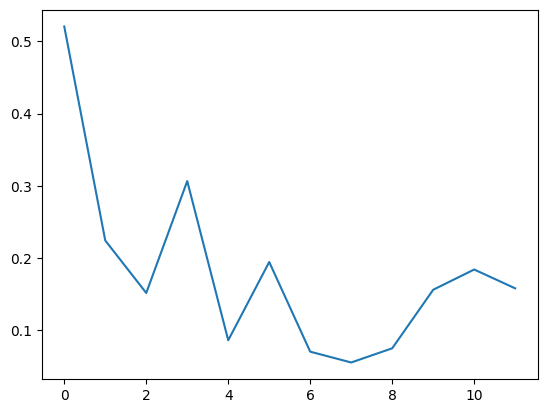

In [ ]:
plt.plot(lossval)

In [ ]:
len(lossval)

12

### Save and load a model

In [ ]:
torch.save(model.state_dict(), 'model_nn.pth')

In [ ]:
input_size = 28 * 28
output_size = 10
hidden_size = 500

model = net(input_size, output_size, hidden_size)
model.load_state_dict(torch.load('model_nn.pth'))
model.eval()

net(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)

### Predict

In [ ]:
with torch.no_grad():
    y_test_nn = []
    y_pred_nn = []
    for x_test, y_test in test_loader:
        outputs = model(x_test.reshape(-1, 28*28))
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_nn += predicted.tolist()
        y_test_nn += y_test.tolist()

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test_nn, y_pred_nn))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.97      0.97       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.97       974
           9       0.97      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

